# **실습10. 베이직 seq2seq**

## **0.과제 이해하기**
“seq2seq를 활용하여 숫자 시퀀스를 좌우 반전 시켜라!”
본격적인 활동에 앞서 지난 실습 내용을 복습해보자. 지난 활동은 RNN을 활용한 분류 작업으로, 어떤 시퀀스가 주어졌을 때 동일한 반쪽을 갖고 있는 다른 시퀀스를 찾아내는 것이었다. 이전 활동에서 살펴봤듯 RNN 모델 아키텍쳐는 순차적 데이터(sequence), 즉 텍스트와 같이 ‘순서’ 개념이 중요한 데이터를 다룰 때 유용하다. 이번 시간에는 RNN이 확장된 형태인 시퀀스 투 시퀀스(seq2seq) 모형을 배워볼 것이며, 실습 역시 지난 번과 마찬가지로 순차적 데이터인 시퀀스를 활용하는 활동이 될 것이다. 

이번 실습의 과제는, 주어진 숫자 시퀀스를 좌우반전시키는 것이다. 컴퓨터 상에서 언어를 다룰 때, 언어를 변형해야 하는 상황을 자주 마주하게 된다. 이번 과제 역시 일종의 언어 변형 문제라 생각해볼 수 있으며, 그 내용은 간단하다. 일련의 숫자 시퀀스가 주어지면 seq2seq 모델을 활용하여 해당 시퀀스를 뒤집어 좌우반전시키면 된다. 

>과제 예시  
$[2,4,7,1,3]→[3,1,7,4,2]$  
  

지난 활동에서와 마찬가지로, 우리는 시퀀스를 구성하는 각 숫자(0~9)를 one-hot 인코딩으로 나타낼 것이다. 지난 번과 다른 점은, 시퀀스의 시작과 끝을 나타내는 토큰 두 개, 즉 Start 토큰과 End 토큰을 추가적으로 사용할 것이라는 점이다. 여기서 Start 토큰은 숫자 10에, End 토큰은 숫자 11에 대응되도록 설정할 것이다. 이같은 방식으로 숫자를 새롭게 표현하면, 이하와 같이 (12,)의 shape을 가진 벡터가 12개 생성될 것이다.  

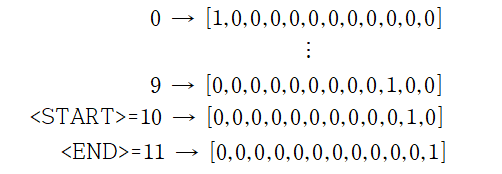



여기서 잠깐. [4, 7, 5, 1]과 같은 simple RNN 모델의 경우 데이터 생성 시 Start 토큰을 사용하지 않고 End 토큰만 활용하면 된다. 따라서 one-hot 인코딩의 결과는 이하와 같은 형태가 나오게 되며, 정답에 해당되는 타겟 라벨(=해당 시퀀스를 뒤집은 형태)은 [1, 5, 7, 4, 11]이 될 것이다.



```
[[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]  # 4 
 [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]  # 7
 [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]  # 5
 [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]  # 1
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]] # <End> (11)
```



 그러나 이번 실습에서 만들어볼 모델은 seq2seq 모델이며 이것은 simple RNN보다 더 복잡한 형태이다. 따라서, Start 토큰과 END 토큰을 모두 사용할 것이다.

## **1. 배치(Batch) 생성하기**

본격적인 코드 작성에 앞서, 아래 코드를 통해 이번 실습에 필요한 세팅을 진행해보자.

In [ ]:
from collections import defaultdict

import numpy as np

from mynn.layers.dense import dense
from mynn.optimizers.adam import Adam

from mygrad.nnet.losses import softmax_crossentropy
from mygrad.nnet.initializers import glorot_normal
from mygrad.nnet.activations import relu

import mygrad as mg

%matplotlib notebook
import matplotlib.pyplot as plt

우리는 효율적인 학습을 위해 여러 시퀀스에 대한 batch를 생성해볼 것이다. 이때 batch는 한국어 표현으로는 영어 발음 그대로 ‘배치’라고 한다. batch란, 학습 과정에서 효율을 높이고자 ‘입력 데이터를 일괄로 처리하기 위해 묶는 것’을 가리킨다.만든 batches는 학습 과정에서 모델에 전달될 것이다. 그렇다면 batch를 어떠한 형태로 구성하여 모델의 input으로 입력할 것인가? batch-size가 N이고 오리지널 데이터의 자리수 길이가 T-1이라 할 때, 우리는 (T,N,C=12)의 shape를 가진 one-hot 인코딩 배열이 되도록 batches를 만들 것이다. 



---
(T,N,C=12)의 모양으로 batch를 구성하는 방식은, N을 0차원 자리에 두었었던 예전의 batch 구성 방식 (N,T,C)와 다른 것이다. 그러나 궁극적으로는 NumPy의 행렬곱 broadcasting 방식 에 의하여, 예전과 동일한 방식으로 내적을 수행하게 된다고 볼 수 있다. 아래 코드를 통해, (T,N,C) 모양의 batch와 (N,T,C) 모양의 batch가 각각 arr와의 행렬곱을 진행하면 궁극적으로는 두 결과가 동일함을 확인할 수 있다.

- 이때 numpy의 broadcasting 성질은 중요하므로, 잘 이해되지 않는다면 구글링을 통해 개념을 익혀보자.


```
T, N, C = 2, 3, 4
seq_then_batch = np.arange(T * N * C).reshape(T, N, C)

#예전의 batch 모양인 (N, T, 5) 만들기
batch_then_seq = seq_then_batch.transpose(1, 0, 2)

arr = np.arange(C * 5).reshape(C, 5)

# shape-(T, N, C) x shape-(C, 5) -> shape-(T, N, 5)
seq_then_batch = seq_then_batch @ arr
# shape-(N, T, C) x shape-(C, 5) -> shape-(N, T, 5)
batch_then_seq = batch_then_seq @ arr

np.all(seq_then_batch == batch_then_seq.transpose(1, 0, 2))

```


---





 위의 고려사항을 염두에 두고, 주어진 숫자 시퀀스(digit-sequences)에 대한 배치를 생성하는 아래의 함수 generate_batch를 살펴보자. (이때 숫자 시퀀스는 one-hot 인코딩을 거친 형태이다.) generate_batch 함수 및 코드에 대한 개괄적인 설명은, 주석으로 삽입할 시 셀이 너무 길어지므로 셀 바깥으로 빼두겠다. 직접 함수를 실행시켜보면서 함수의 기능을 직관적으로 이해해보도록 하자. 

>generate_batch 함수란, 여러 숫자 시퀀스로 이루어진 batch를 생성하고 이에 대응하는 one-hot 인코딩을 만들어내는 함수이다. 
>- 이때 각 숫자 시퀀스는 T-1의 길이를 가지며 END 토큰을 포함하지 않는다.
>- T-1의 값은 랜덤으로 생성된다.
    
    매개변수
    ----------
    seq_len_min : int, optional (default=1)
       가능한 패턴 길이 가운데 가장 짧은 것.
       start 토큰과 end 토큰이 포함되지 않음
       
    seq_len_max : int, optional (default=20)
       가능한 패턴 길이 가운데 가장 긴 것,
       start 토큰과 end 토큰이 포함되지 않음
       
    batch_size : int, optional (default=10)
        배치 크기. 생성하는 sequence의 개수
    
    반환 값
    -------
    Tuple[numpy.ndarray, numpy.ndarray, numpy.ndarray]
        1. one-hot 형태의 숫자 시퀀스들(end 토큰 포함); 모양-(T, N, 12)
        2. 오리지널 숫자 시퀀스들이 반전된 형태인, 타겟 숫자 시퀀스들(end 토큰을 포함); 모양-(T, N)
        3. 숫자들로 이루어진 오리지널 sequences; shape-(T-1, N)
    
    예시
    --------
    >>> generate_batch(2, 3, batch_size=2)
    (array([[[0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]],
 
        [[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]],
 
        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]]], dtype=float32),
     array([[ 0,  6],
            [ 6,  3],
            [11, 11]]),
     array([[6, 3],
            [0, 6]]))




In [ ]:
def generate_batch(seq_len_min=1, seq_len_max=20, batch_size=10):
    T_1 = np.random.randint(seq_len_min, seq_len_max + 1)
    digits = np.random.randint(0, 10, (T_1, batch_size))
    one_hot_x = np.zeros((T_1 + 1, batch_size, 12), dtype=np.float32)
    one_hot_x[np.arange(T_1).reshape(-1, 1), np.arange(batch_size), digits] = 1
    one_hot_x[-1, :, -1] = 1
    ends = np.full(batch_size, 11).reshape(1, -1)
    y = np.concatenate([digits[::-1], ends], axis=0)
    return one_hot_x, y, digits


각 코드를 분석하자면,  


```
T_1 = np.random.randint(seq_len_min, seq_len_max + 1)
    # T-1 값
    # 하나의 sequence를 랜덤으로 생성 ([seq_len_min, seq_len_max] 범위 내의 길이) 

digits = np.random.randint(0, 10, (T_1, batch_size))
    # [0-9] 범위의 숫자들로 구성된 (T-1, N) 크기의 시퀀스를 랜덤으로 생성하여, `digits`에 저장
    # N: 우리의 모델이 번역할, T-1 길이의 정수 값 시퀀스 N개를 나타냄
    #
    # E.g. 만약 T-1 = 3, N = 2 일 때 생성하는 배열:
    #
    #  array([[3, 9],
    #         [2, 5],
    #         [9, 3]])
    # seq-0: 3, 2, 9
    # seq-1: 9, 5, 3

one_hot_x = np.zeros((T_1 + 1, batch_size, 12), dtype=np.float32)
    # 배열 `one_hot_x`
    # 0으로 구성된 배열 하나(one-hot 인코딩 sequences를 채우는 역할)를 생성
    # 배열의 크기: (T, N, 12) (이때 N = batch-size)
    # 데이터 타입: float-32
    # 배열 길이: T (source sequence가 <end> 토큰을 포함하고 <start>를 포함하지 않기 때문)

one_hot_x[np.arange(T_1).reshape(-1, 1), np.arange(batch_size), digits] = 1
    # `digits`의 역할: `one_hot_x`을 적절한 one-hot encodings으로 채우는 데 사용
    # 이하의 두 방식 중 하나를 통해 구현
    # 1_추가적인 인덱싱: 0으로 채워진 3차원 배열 가운데, 1이 들어가야 할 자리에 1 입력
    # one_hot_x[np.arange(T_1).reshape(-1, 1), np.arange(batch_size), digits] = 1
    # 
    # 2_for 반복문 사용:
    # for ind in np.ndindex(digits.shape):
    #     one_hot_x[ind + (digits[ind],)] = 1

one_hot_x[-1, :, -1] = 1
    # `one_hot_x`에서 모든 batches에 대한 마지막 토큰에 <END>를 위치시킴
    # <END> 토큰은 이 행렬에서 T번째 시퀀스 엔트리와 12번째 인코딩 지점에 위치함
    # 이 선택된 subarray를 1로 지정하고자 함.

ends = np.full(batch_size, 11).reshape(1, -1)
    # 타겟 시퀀스에 사용할 <END> 토큰 생성
y = np.concatenate([digits[::-1], ends], axis=0)
    # input 시퀀스가 뒤집힌 형태인 타겟 시퀀스 생성
    # 타겟 시퀀스의 shape는 (T, N), T번째 행에 <END>토큰인 `11` 존재

return one_hot_x, y, digits
    # 조건에 부합하는 행렬 결과 반환

```



지금까지 '1. 배치(Batch) 생성하기' 파트를 통해 batch를 생성해보았다. 이렇게 생성한 batches를 input으로 넣어주면 학습의 효율이 높아질 수 있다. 지난 시간에 배운 RNN 모델 역시 이러한 batches를 학습과정에 활용하였으며, 우리가 이번 노트에서 다룰 "시퀀스 투 시퀀스", 이른바 seq2seq 모델 역시 RNN을 구성요소로 취하기에 마찬가지로 batches를 활용할 예정이다.  

>본 마크다운 파일에서는 실습 위주로 다루고자 하니, 본격적인 seq2seq 개념을 다루는 2(seq2seq 개념 만나기), 3(수식으로 seq2seq 이해하기)의 내용은 본책 3권을 참고하여 이해하도록 하자. 우리는 이제 실습과 관련된 '4. 코드로 seq2seq 표현하기'로 바로 넘어가볼 것이다.

## **4. 코드로 seq2seq 표현하기**

지금까지 인코딩과 디코딩 과정을 수식을 기반으로 분석해보았다. 이제는 코드로 표현해볼텐데, 이전 노트북의 RNN 클래스를 바탕으로 새로운 seq2seq 모델을 만들고 batches를 활용한 학습을 진행할 것이다. 우선, 아래 코드를 통해 output과 hidden descriptor를 모두 생성하는 simple-cell RNN을 구현해보자. 이때 주어진 코드를 수정할 필요는 없다.


In [ ]:
class RNN:
    def __init__(self, dim_input, dim_recurrent, dim_output):
        """ RNN에 필요한 모든 레이어 초기 설정
        
        매개변수
        ----------
        dim_input: int 
            RNN을 지나가는 데이터의 차원 (C)
        
        dim_recurrent: int
            RNN에 있는 hidden state의 차원 (D)
        
        dim_output: int
            RNN의 output의 차원 (K)
        """
        self.fc_x2h = dense(dim_input, dim_recurrent,  weight_initializer=glorot_normal)
        self.fc_h2h = dense(dim_recurrent, dim_recurrent, weight_initializer=glorot_normal, bias=False)
        self.fc_h2y = dense(dim_recurrent, dim_output, weight_initializer=glorot_normal)

   def __call__(self, x, h=None):
        """ RNN에 대한 완전한 순방향 패스(full forward pass)를 수행.
        
        매개변수
        ----------
        x: Union[numpy.ndarray, mygrad.Tensor], shape=(T, N, C)
            batch의 각 시퀀스에 대한 one-hot 인코딩
        
        h: Optional[Union[numpy.ndarray, mygrad.Tensor]], shape=(1, N, D)
            초기 hidden dimension state h_0에 대한 옵션 설정
            지정되지 않을 경우 영행렬 할당.
        
        반환 값
        -------
        Tuple[y, h]
            y: mygrad.Tensor, shape=(T, N, K)
                각 RNN step에 대한 최종 분류 점수
            h: mygrad.Tensor, shape=(T, N, D)
                각 RNN step에서 계산된 hidden states (초기 상태 h_0는 제외)
        """
        N = x.shape[1]
        D = self.fc_h2h.weight.shape[0]
        
        h_t = np.zeros((1, N, D), dtype=np.float32) if h is None else h
        h = []
        
        for x_t in x:
            h_t = relu(self.fc_x2h(x_t[np.newaxis]) + self.fc_h2h(h_t))
            h.append(h_t)
        
        h = mg.concatenate(h, axis=0)
        
        return self.fc_h2y(h), h

       @property
    def parameters(self):
        """ 모델 내 모든 매개변수를 보여주는 편리한 함수
        이것은 `model.parameters`를 통해 속성(attribute)으로 액세스 가능
        
        반환 값
        -------
        Tuple[Tensor, ...]
            우리 모델에 대한 모든 학습 가능한 매개변수를 포함하는 튜플
        """
        # 여기에 코드 작성  


simple RNN이 준비되었으니, 이번에는 각 디코더의 output을 다음 input으로 변환하는 데 필요한 도구를 설정하는 것부터 시작해보자.

아래의 함수 one_hot_encode_pediction을 완성해보자.  
- 입력: 분류 점수에 대한 하나의 텐서  
- 반환: 예측 점수가 가장 높은 클래스에 대한 float32 one-hot 인코딩 배열  
- tip: 이때 NumPy의 argmax 기능이 특히 도움이 될 것이다.  


In [ ]:
def one_hot_encode_prediction(y_t):
    """ 분류 점수 y_t에 대한 하나의 batch를 입력받으면, 가장 높은 점수를 가진 클래스에 해당하는 원-핫 인코딩을 반환하는 함수.
    
    매개변수
    ----------
    y_t: mygrad.Tensor, shape=(1, N, K)
        seq2seq 디코딩의 한 step으로부터 예측된 분류 점수
    
    반환 값
    -------
    s_t1: numpy.ndarray, shape=(1, N, K), dtype=np.float32
        y_t에서의 가장 큰 예측 점수에 해당하는 레이블의 one-hot 인코딩. 
        float32의 NumPy 배열.
    
    Notes
    -----
    N : batch size
    K : 클래스 개수 (i.e. vocabulary의 크기)
    """
    # 여기에 코드 작성


다음 셀을 실행하여 구현을 확인해보자.

In [ ]:
y_t = mg.random.randn(1, 4, 6)
s_t1 = one_hot_encode_prediction(y_t)

assert isinstance(s_t1, np.ndarray) # check if s_t1 is numpy array
assert issubclass(s_t1.dtype.type, np.float32) # check if s_t1 is float array
assert y_t.shape == s_t1.shape # check if s_t1 has correct shape
assert np.all(s_t1.sum(axis=-1) == np.ones((1, 4))) # check if one-hot encoded
assert np.all(np.argmax(y_t, axis=-1) == np.argmax(s_t1, axis=-1)) # check if correct one-hot encodings

print("Success!")


이제 seq2seq 클래스를 작성해보자. 다행히 이 작업에 필요한 주요 요소들이 모두 RNN 클래스와 one_hot_encode_pediction 함수 내에 존재하니, 이를 잘 활용하면 된다.

In [ ]:
class seq2seq:
    def __init__(self, dim_input, dim_recurrent, dim_output):
        """ seq2seq에 필요한 모든 RNN layers 초기 설정
        
        매개변수
        ----------
        dim_input: int 
            RNN을 지나가는 데이터의 차원 (C)
        
        dim_recurrent: int
            RNN에 있는 hidden state의 차원 (D)
        
        dim_output: int
            RNN의 output의 차원 (K)
        
        Notes
        -----
        이 특정 문제에 대해, input의 차원과 output의 차원은 동일(C = K).
        그러나 이것이 일반적인 경우는 아님.
        """
        # 두 개의 RNNs - 인코더와 디코더 - 생성(인스턴스화)
        # 두 개 모두 `dim_input`, `dim_recurrent`, `dim_output` 사용
        # 여기에 코드 작성

  def __call__(self, x):
        """ seq2seq에 대한 완전한 순방향 패스(full forward pass)인 인코딩과 디코딩을 수행.
        
        매개변수
        ----------
        x: Union[numpy.ndarray, mygrad.Tensor], shape=(T, N, C)
            batch의 각 시퀀스에 대한 one-hot 인코딩
        
        반환 값
        -------
        y: mygrad.Tensor, shape=(T, N, K)
            각 디코더 step의 output으로부터 도출된 최종 분류 점수
        """
        # 인코더 RNN을 통해 input 시퀀스 실행
        # hidden states를 변수 `enc_h`에 저장.
        # hidden states의 shape는 (T, N, D)
        # 여기에 코드 작성
 
        # `enc_h`으로부터 마지막 hidden descriptor에 접근
        # 디코더에 대한 첫 번째 h_{-1}로서 사용됨
        # dimensions을 보존할 것을 명심해야 함
        # 이 hidden descriptor의 shape이 (1, N, D)가 될 수 있도록
        # 여기에 코드 작성
        
        # 리스트 `y`를 생성하여 예측 점수 y_t를 저장
        # 여기에 코드 작성
        
        # 디코더에 초기 input을 생성:
        # float32 형식이고 shape은 (1, N, C)인 배열
        # <START> 토큰에 대한 one-hot 인코딩
        # 우리가 10이라고 표현했던 것
        # 여기에 코드 작성
        
        # 새로운 y_t, h_t를 디코더로부터 반복적으로 생산
        # 리스트 `y`에서 각 y_t를 저장.
        # `one_hot_encode_prediction`을 사용하여,
        # output y_t으로부터 다음 디코더 input인 s_{t+1}을 입력받음.
        # 표준적인 for-반복문이 적절함.
        # 여기에 코드 작성
        
        # 0번째 축을 따라 `y`에 저장된 y_t 텐서들을 연결(concatenate).
        # 결과를 반환.
        # 여기에 코드 작성

   @property
    def parameters(self):
        """ 모델 내 모든 매개변수를 취하는 편리한 함수
        이것은 `model.parameters`를 통해 속성(attribute)으로 액세스 가능
        
        반환 값
        -------
        Tuple[Tensor, ...]
            우리 모델에 대한 모든 학습 가능한 매개변수를 포함하는 튜플
        """
        # 여기에 코드 작성


noggin plot을 만들어 loss와 accuracy를 추적해보자.

In [ ]:
from noggin import create_plot
# 여기에 코드 작성


seq2seq 모델과 Adam Optimizer를 인스턴스로 실제화해보자.  
우선, Adam의 매개변수 recurrent_dim의 값의 경우 default인 50으로 시작해보자.

In [ ]:
# 여기에 코드 작성

이번에는 학습을 위한 loop를 작성해보자. 이 loop는 softmax_crossentropy를 사용하여 loss를 계산할 것이다. 그러나 MyGrad의 softmax_crossentropy를 구현하려면, input에 대한 아래의 조건을 충족해야 한다. 첫 번째 input인 x의 shape은 (N, C)이고, 두 번째 input인 y_true의 shape은 (N,)이어야 한다. 이를 우리 모델에 대입해보면,
1. 우리 모델 output의 경우, 우리가 sequences에 대한 batches를 가지고 작업하고 있기 때문에, 그 shape이 (T, N, K)여야 한다. 또한, 정답 값(truth values)의 shape은 (T, N)이어야 한다. 
2. 우리의 input들을 softmax_crossentropy와 양립가능하도록 만들기 위해, 우리는 x와 y_true가 각각 (T * N, C)와 (T * N,)의 형태로 reshape할 수 있다. 이를 통해 손실 함수를 위한 새 버전을 재정의할 필요 없이, 토큰당 softmax-crossentropy 손실값을 계산하고 평균화할 수 있다.

이제, 만든 모델을 10000번 반복하여 학습시켜라. 이때 배치 크기는 100, 시퀀스의 길이 범위는 1에서 20 사이로 지정하겠다.


In [ ]:
# 여기에 코드 작성

아래 셀을 실행하여 길이가 다양한 시퀀스에서 모델의 정확도를 평가하라. seq2seq 모델은 기본 RNN과 어떻게 다른가? 놀라운 점은 무엇이며, 만약 그렇지 않다면 이러한 결과를 예상한 이유가 무엇인가? 당신의 생각을 다른 사람들과 논해보자.

In [ ]:
length_total = defaultdict(int)
length_correct = defaultdict(int)

with mg.no_autodiff:
    for i in range(50000):
        if i % 5000 == 0:
            print(f"i = {i}")
        x, target, sequence = generate_batch(1, 20, 1)

        output = model(x)

        length_total[sequence.size] += 1
        if np.all(np.argmax(output, axis=-1) == target):
            length_correct[sequence.size] += 1

fig, ax = plt.subplots()
x, y = [], []
for i in range(1, 20):
    x.append(i)
    y.append(length_correct[i] / length_total[i])
ax.plot(x, y);
